<a href="https://colab.research.google.com/github/tg-bomze/Style-Transfer-Collection/blob/master/(Photo)_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">style-transfer</font></b>

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [style-transfer](https://github.com/jeremycochoy/style-transfer)

Article: [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Gatys_Image_Style_Transfer_CVPR_2016_paper.html)

Creators: **[Jeremy Cochoy](https://github.com/jeremycochoy), [Greg Surma](https://github.com/gsurma).**

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

---


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, нажмите на кнопку (куда указывает красная стрелка), после чего дождитесь завершения выполнения блока.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary components</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить все необходимые компоненты</font></b>

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import copy

import os
import cv2
import imageio
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output
from IPython.display import HTML
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

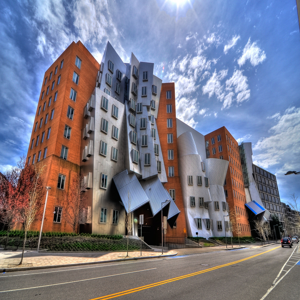

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload content image</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить основное фото</font></b>

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
os.rename(fn, fn.replace(" ", ""))
fn = fn.replace(" ", "")
content_img = "content." + fn.split(".")[-1]
!mv -f $fn $content_img

im = Image.open(content_img)
(width_cont, height_cont) = im.size
content_img_max = max(width_cont, height_cont)
content_img_min = min(width_cont, height_cont)

display(Image.open(content_img).resize((300, 300)))

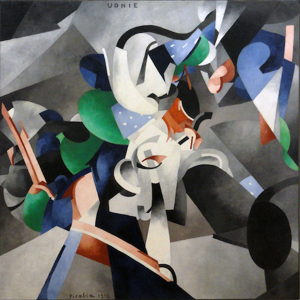

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload style image</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить фото со стилем</font></b>

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
os.rename(fn, fn.replace(" ", ""))
fn = fn.replace(" ", "")
style_img = "style." + fn.split(".")[-1]
!mv -f $fn $style_img

im = Image.open(style_img)
(width, height) = im.size
style_img_max = max(width, height)
style_img_min = min(width, height)

display(Image.open(style_img).resize((300, 300)))

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Style Transfer</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Перенести стиль из фото на видео</font></b>
%%time

ITERATIONS = 10 #@param {type:"slider", min:5, max:30, step:1}
#@markdown ---
IMAGE_WIDTH = width_cont
IMAGE_HEIGHT = height_cont
CONTENT_WEIGHT = 1 #@param {type:"slider", min:0, max:1, step:0.025}
STYLE_WEIGHT = 0.01 #@param {type:"slider", min:0, max:1, step:0.01}
TOTAL_VARIATION_WEIGHT = 15 # Weight of the total variation loss
INPUT_IMAGE = 'noise' #@param ["noise", "content", "style"]

content_layers = ['conv_1', 'conv_2', 'conv_4']
style_layers = ['conv_2', 'conv_3', 'conv_4', 'conv_7', 'conv_10', 'conv_8']

content_image_path = "content.png"
style_image_path = "style.png"
output_image_path = "result.png"
combined_image_path = "combined.png"

content_url = content_img
style_url = style_img

# The function wich allow us to download / open an image
def open_image(url):
  if url.startswith("http"):
    return Image.open(BytesIO(requests.get(url).content))
  else:
    return Image.open(url)

content_image = open_image(content_url)
content_image = content_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
content_image.save(content_image_path)

style_image = open_image(style_url)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)

class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    # We 'detach' the target content from the tree used
    # to dynamically compute the gradient: this is a stated value,
    # not a variable.
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = self.gram_matrix(target_feature).detach()

  def forward(self, input):
    G = self.gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

  @staticmethod
  def gram_matrix(input):
    a, b, c, d = input.size()
    # Here:
    # a is the batch size(=1)
    # b is the number of feature maps
    # (c,d) are the dimensions of a feature map

    # We reshape the activation layer into a collection of feature vectors
    features = input.view(a * b, c * d)

    # Compute the gram product
    G = torch.mm(features, features.t())  

    # We 'normalize' the values of the gram matrix
    # by dividing by the norm of gram matrix filled with ones.
    return G.div((a * b * c * d) ** 0.5)

def total_variation_loss(x): # Expect a mini batch of dim NxWxH
  image_height = x.shape[1]
  image_width = x.shape[2]
  dx = x[:, :image_height-1, :image_width-1, :] - x[:, 1:, :image_width-1, :]
  dy = x[:, :image_height-1, :image_width-1, :] - x[:, :image_height-1, 1:, :]
  loss = (dx ** 2 + dy ** 2).sum() ** 0.5
  # Return loss normalized by image and batch size
  return loss / (image_width * image_height * x.shape[0])

# Create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    # Reshape the mean and std to make them [C x 1 x 1] so that they can
    # directly broadcast to image Tensor of shape [B x C x H x W].
    # B is batch size. C is number of channels. H is height and W is width.
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    # Normalize img
    return (img - self.mean) / self.std

# Neural network used.
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Normalization mean and standard deviation.
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

def get_model_and_losses(style_img, content_img,
                               cnn=cnn,
                               cnn_normalization_mean=cnn_normalization_mean,
                               cnn_normalization_std=cnn_normalization_std):
  # We make a deep copy of vgg19 in order to not modify the original
  cnn = copy.deepcopy(cnn)
  
  # Normalization module
  normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

  # This list will contain the losses computed by the network.
  content_losses = []
  style_losses = []

  # We rebuild the model as a nn sequential whose first layer is
  # our normalization layer.
  model = nn.Sequential(normalization)

  # We brows the layer of `cnn` and stack them into `model`.
  i = 0  # Incremented every time we see a conv layer.
  for layer in cnn.children():

    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        # The in-place version doesn't play very nicely with the ContentLoss
        # and StyleLoss we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    # Check if the layer we just added was in the content layer list.
    # If so, we just stack a Content Loss layer.
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)

    # Check if the layer we just added was in the style layer list.
    # If so, we just stack a Style Loss layer.
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)

  # Now we trim off the layers after the last content and style losses
  # to keep the model as small as possible.
  for i in range(len(model) - 1, -1, -1):
      if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
          break

  model = model[:(i + 1)]

  return model, style_losses, content_losses

def image_to_tensor(image):
  # Transform to tensor
  image = transforms.ToTensor()(image)
  # Fake batch dimension required to fit network's input dimensions
  image = image.unsqueeze(0)
  # Move to the right device and convert to float
  return image.to(device, torch.float)

content_img = image_to_tensor(content_image)
style_img = image_to_tensor(style_image)

# Reconvert a tensor into PIL image
def tensor_to_image(tensor):
  img = (255 * tensor).cpu().detach().squeeze(0).numpy()
  img = img.clip(0, 255).transpose(1, 2, 0).astype("uint8")
  return Image.fromarray(img)

#@title This is the _input_ image
if INPUT_IMAGE == 'noise':
  input_img = torch.randn(content_img.data.size(), device=device)
elif INPUT_IMAGE == 'content':
  input_img = content_img.clone()
elif INPUT_IMAGE == 'style':
  input_img = style_img.clone()
else:
  image = open_image(INPUT_IMAGE).resize((IMAGE_SIZE, IMAGE_SIZE))
  input_img = image_to_tensor(image)
  input_img += torch.randn(content_img.data.size(), device=device)*0.1

# To visualise it better, instead of clipping values, we rescale
# them to fit [-1,1], and convert to an image. This is mostly because
# the visualization given is closer to what the actual values stored
# in the tensor are.
if INPUT_IMAGE == 'noise':
  img = transforms.ToPILImage()(input_img[0].cpu())
else:
  img = tensor_to_image(input_img[0])

def get_input_optimizer(input_img):
  # This line tell LBFGS what parameters we should optimize
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  #optimizer = optim.Adam([input_img.requires_grad_()])
  return optimizer

def show_evolution(tensor, history=[], title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = tensor_to_image(image)
    # Display a big figure
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    # Image
    plt.subplot(121)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    # Losses
    ax = plt.subplot(122)
    plt.yscale('log')
    plt.title('Losses')
    import numpy as np
    history = np.array(history).T
    plt.plot(history[0], label='Style')
    plt.plot(history[1], label='Content')
    plt.plot(history[2], label='Variation')
    plt.plot(history[3], label='Sum')
    plt.legend(loc="upper right")
    # Finaly show the graph
    plt.show()
    # Display a textual message
    print('Style Loss : {:4f} Content Loss: {:4f} Variation Loss: {:4f} Sum: {:4f}'.format(
        history[0][-1], history[1][-1], history[2][-1], history[3][-1]))
    
print('Building the style transfer model..')
model, style_losses, content_losses = get_model_and_losses(style_img, content_img)
optimizer = get_input_optimizer(input_img)

print('Optimizing..')
iterations = 0
history=[]
while iterations <= ITERATIONS * 100:
  # Compute the loss and backpropagate to the input_image.
  # (The LBFGS optimizer only accept work through closures.)
  def closure():
      global history
      global iterations
      
      optimizer.zero_grad()
      
      # Compute the total variation loss
      variation_score = total_variation_loss(input_img) * TOTAL_VARIATION_WEIGHT
      # Compute the features through the model
      model(input_img)
      # Compute style and content losses
      style_score = sum(sl.loss for sl in style_losses)
      style_score *= STYLE_WEIGHT / len(style_losses)
      content_score = sum(cl.loss for cl in content_losses)
      content_score *= CONTENT_WEIGHT / len(content_losses)
      # Our global loss is the sum of the 3 values
      loss = style_score + content_score + variation_score
      # Save the value of loss in order to draw them as a graph
      history += [[style_score.item(), content_score.item(), variation_score.item(), loss.item()]]

      # If the iteration is a multiple of 100, display some informations
      iterations += 1
      if iterations % 100 == 0:
          show_evolution(input_img.data.clone().detach().clamp(0, 1), history, title="Iteration %d:" % iterations)
      
      # Backpropagate gradients and leave the optimizer do his job.
      loss.backward()
      return loss

  optimizer.step(closure)

CPU times: user 3min 29s, sys: 2min 11s, total: 5min 40s
Wall time: 5min 53s


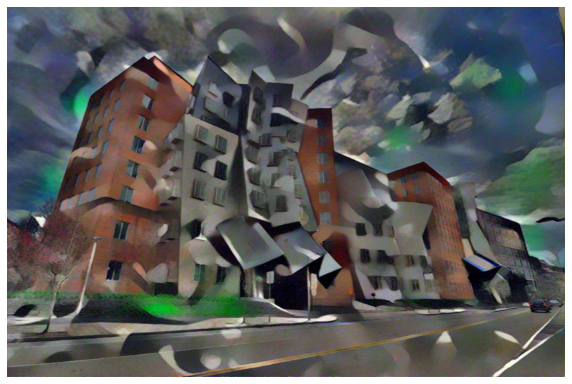

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Open the final image</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Открыть итоговый результат</font></b>
fig = plt.figure(figsize=(10, 10))
img = plt.imread(output_image_path)
plt.axis('off')
plt.imshow(img)

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Download the final image</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Скачать итоговый результат</font></b>
files.download(output_image_path)